In [1]:
from spirl.modules.subnetworks import VQCDTPredictor
# 绘制代码
import torch
import torch.nn as nn
from torch.utils import data
import numpy as np
import copy
import matplotlib as mpl
from spirl.configs import local

def get_binary_index(tree):
    """
    Get binary index for tree nodes:
    From

    0
    1 2
    3 4 5 6 

    to 

    '0'
    '00' '01' 
    '000' '001' '010' '011'

    """
    index_list = []
    for layer_idx in range(0, tree.max_depth+1):
        index_list.append([bin(i)[2:].zfill(layer_idx+1) for i in range(0, np.power(2, layer_idx))])
    return np.concatenate(index_list)

def path_from_prediction(tree, idx):
    """
    Generate list of nodes as decision path, 
    with each node represented by a binary string and an int index
    """
    binary_idx_list = []
    int_idx_list=[]
    idx = int(idx)
    for layer_idx in range(tree.max_depth+1, 0, -1):
        binary_idx_list.append(bin(idx)[2:].zfill(layer_idx))
        int_idx_list.append(2**(layer_idx-1)-1+idx)
        idx = int(idx/2)
    binary_idx_list.reverse()  # from top to bottom
    int_idx_list.reverse() 
    return binary_idx_list, int_idx_list

def draw_tree(original_tree, input_img=None, show_correlation=False, DrawTree=None, savepath=''):
    '''
    Need to carefully select several configurations for well displaying trees for different environments, e.g. CartPole and LunarLander-v2
    '''
    # 整体
    aspect_inners = 0.6
    aspect_leaves = 0.6
    arrow_color = '#262626'

    # # 局部
    # aspect_inners = 1
    # aspect_leaves = 1
    # arrow_color = '#262626'

    import itertools
    import numpy as np
    import matplotlib.pyplot as plt
    from matplotlib.gridspec import GridSpec
    from matplotlib.patches import ConnectionPatch

    tree = copy.copy(original_tree)
    if DrawTree=='FL': # draw the feature learning tree
        tree.inner_node_num = tree.num_fl_inner_nodes
        tree.max_depth = tree.feature_learning_depth
        tree.leaf_num = tree.num_fl_leaves
        inner_nodes_name='fl_inner_nodes.weight'
        leaf_nodes_name='fl_leaf_weights'
        input_shape=(tree.input_dim,)

    elif DrawTree == 'DM':  # draw the decision making tree
        tree.inner_node_num = tree.num_dc_inner_nodes
        tree.max_depth = tree.decision_depth
        tree.leaf_num = tree.num_dc_leaves
        inner_nodes_name='dc_inner_nodes.weight'
        leaf_nodes_name='dc_leaves'
        input_shape=(tree.num_intermediate_variables,)
        # input_img=tree.max_feature_value.squeeze().detach().cpu().numpy()  # replace the original input image to be intermediate feature value

    def _add_arrow(ax_parent, ax_child, xyA, xyB, color='black', linestyle=None):
        '''Private utility function for drawing arrows between two axes.'''
        con = ConnectionPatch(xyA=xyA, xyB=xyB, coordsA='data', coordsB='data',
                              axesA=ax_child, axesB=ax_parent, arrowstyle='<-,head_length=0.8,head_width=0.4',
                              color=color, linewidth=tree.max_depth-2, linestyle=linestyle)
        ax_child.add_artist(con)

    inner_nodes = tree.state_dict()[inner_nodes_name]
    leaf_nodes = tree.state_dict()[leaf_nodes_name]
    binary_indices = get_binary_index(tree)
    inner_indices = binary_indices[:tree.inner_node_num]
    leaf_indices = binary_indices[tree.inner_node_num:]
    
    if len(input_shape) == 3:
        img_rows, img_cols, img_chans = input_shape
    elif len(input_shape) == 1:
        img_rows, img_cols = input_shape[0], input_shape[0]

    if DrawTree == 'FL':  # each leaf contains vectors of number: tree.args['num_intermediate_variables'] 
        leaf_nodes = leaf_nodes.view(tree.leaf_num, tree.num_intermediate_variables, tree.input_dim)

    kernels = dict([(node_idx, node_value.cpu().numpy().reshape(input_shape)) for node_idx, node_value in zip (inner_indices, inner_nodes[:, 1:]) ])
    biases = dict([(node_idx, node_value.cpu().numpy().squeeze()) for node_idx, node_value in zip (inner_indices, inner_nodes[:, :1]) ])
    leaves = dict([(leaf_idx, np.array([leaf_dist.cpu().numpy()])) for leaf_idx, leaf_dist in zip (leaf_indices, leaf_nodes) ])
    n_leaves = tree.leaf_num
    assert len(leaves) == n_leaves

    fig = plt.figure(figsize=(2*n_leaves, n_leaves/2), facecolor='white')  # for cartpole
    gs = GridSpec(tree.max_depth+1, n_leaves*2, height_ratios=[1]*tree.max_depth+[0.5]) # 高度调整

    # Grid Coordinate X (horizontal)
    gcx = [list(np.arange(1, 2**(i+1), 2) * (2**(tree.max_depth+1) // 2**(i+1)))
           for i in range(tree.max_depth+1)]
    gcx = list(itertools.chain.from_iterable(gcx))
    axes = {}
    path = ['0']

    import matplotlib.pyplot as plt
    import matplotlib.colors as mcolors

    # 权重颜色
    cmap = plt.get_cmap('coolwarm')
    new_cmap = cmap(np.linspace(0.08, 0.92, 256))  # 调整对比度，避免最强的红色和蓝色
    # 创建新的颜色映射
    new_cmap = mcolors.LinearSegmentedColormap.from_list('less_intense_coolwarm', new_cmap)

    imshow_args = {'origin': 'upper', 'interpolation': 'None', 'cmap': plt.get_cmap(new_cmap)}
    imshow_args = {'origin': 'upper', 'interpolation': 'None', 'cmap': 'Oranges'} # OrRd、Reds、YlOrBr

    # 权重参数
    kernel_min_val = np.min([np.min(kernel) for kernel in kernels.values()])
    kernel_max_val = np.max([np.max(kernel) for kernel in kernels.values()])
    leaf_min_val = np.min([np.min(leaf) for leaf in leaves.values()])
    leaf_max_val = np.max([np.max(leaf) for leaf in leaves.values()])

    # mkbl、mlsh参数
    kernel_min_val = 0.0
    kernel_max_val = 7.
    leaf_min_val = 0.0 # 小红多
    leaf_max_val = 0.4 # 大蓝多

    # # calvin参数
    # kernel_min_val = 0.0
    # kernel_max_val = 18.
    # leaf_min_val = 0.0 # 小红多
    # leaf_max_val = 0.8 # 大蓝多

    # plot color bar for kernels and leaves separately
    norm = mpl.colors.Normalize(vmin=kernel_min_val,vmax=kernel_max_val)
    sm = plt.cm.ScalarMappable(cmap=imshow_args['cmap'], norm=norm)
    sm.set_array([])
    cbaxes = fig.add_axes([0.01, 0.4, 0.03, 0.2])  # This is the position for the colorbar
    plt.colorbar(sm, ticks=np.linspace(kernel_min_val,kernel_max_val,5), cax = cbaxes)
        
    # draw tree nodes
    for pos, key in enumerate(sorted(kernels.keys(), key=lambda x:(len(x), x))):
        ax = plt.subplot(gs[len(key)-1, gcx[pos]-2:gcx[pos]+2])
        axes[key] = ax
        kernel_image = kernels[key]

        if len(kernel_image.shape)==3: # 2D image (H, W, C)
            ax.imshow(kernel_image.squeeze(), vmin=kernel_min_val, vmax=kernel_max_val, **imshow_args)
        elif len(kernel_image.shape)==1:
            vector_image = np.ones((kernel_image.shape[0], 1)) @ [kernel_image]
            ax.imshow(vector_image, vmin=kernel_min_val, vmax=kernel_max_val, **imshow_args)
        # 保留坐标轴，但去除刻度线和标签
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        # ax.axis('off')

        ax.set_aspect(aspect=aspect_inners) # imp：节点宽高比

        # # 绘制子任务序号
        # if DrawTree!='FL':  # feature learning tree do not have titile indicating the classification 
        #     digits = set([np.argmax(leaves[k]) for k in leaves.keys()
        #                 if k.startswith(key)])
        #     title = ','.join(str(digit) for digit in digits)
        #     plt.title('{}'.format(title))

    imshow_args = {'origin': 'upper', 'interpolation': 'None', 'cmap': 'Greens'} # YlGn

    # draw tree leaves
    for pos, key in enumerate(sorted(leaves.keys(), key=lambda x:(len(x), x))):
        ax = plt.subplot(gs[len(key)-1,
                            gcx[len(kernels)+pos]-1:gcx[len(kernels)+pos]+1])
        axes[key] = ax
        if len(leaves[key].shape)>2:  # output multi-dimension, e.g. intermediate features for feature learning tree
            leaf_image = leaves[key].squeeze(0)
        else:
            leaf_image = np.ones((tree.output_dim, 1)) @ leaves[key]

        def softmax_for_rows(matrix):
            # 对每一行的元素应用 exp 函数，同时减去该行的最大值以避免数值溢出
            exps = np.exp(matrix - np.amax(matrix, axis=1, keepdims=True))
            # 计算每一行的指数之和
            sum_exps = np.sum(exps, axis=1, keepdims=True)
            # 进行归一化，使每一行的和为 1
            probabilities = exps / sum_exps
            return probabilities
        
        leaf_image = softmax_for_rows(leaf_image)

        ax.imshow(leaf_image, vmin=leaf_min_val, vmax=leaf_max_val, **imshow_args)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax.set_aspect(aspect=aspect_leaves) # imp：节点宽高比

        # 绘制子任务序号
        if DrawTree!='FL':  # feature learning tree do not have titile indicating the classification 
            plt.title('{}'.format(np.argmax(leaves[key])), y=-.5)
        
    # add arrows indicating flow
    for pos, key in enumerate(sorted(axes.keys(), key=lambda x:(len(x), x))):
        children_keys = [k for k in axes.keys()
                         if len(k) == len(key) + 1 and k.startswith(key)]
        for child_key in children_keys:
            p_rows, p_cols = axes[key].get_images()[0].get_array().shape
            c_rows, c_cols = axes[child_key].get_images()[0].get_array().shape

            # 调整箭头的起点和终点位置
            parent_position = (p_cols // 2, p_rows - 1)  # 上移1个单位
            child_position = (c_cols // 2, 1 - 1)  # 上移1个单位

            linestyle = None
            _add_arrow(axes[key], axes[child_key], child_position, parent_position, color=arrow_color, linestyle=linestyle)


    # draw input image with arrow indicating flow into the root node
    if input_img is not None:
        ax = plt.subplot(gs[0, 0:4])  # for lunarlander
        img_min_val = np.min(input_img)
        img_max_val = np.max(input_img)
        if len(input_img.shape)==3: # 2D image (H, W, C)
            ax.imshow(input_img.squeeze(), clim=(0.0, 1.0), vmin=img_min_val, vmax=img_max_val, **imshow_args)
        elif len(input_img.shape)==1:
            vector_image = np.ones((input_img.shape[0], 1)) @ [input_img]
            ax.imshow(vector_image, vmin=img_min_val, vmax=img_max_val, **imshow_args)
        ax.axis('off')
        plt.title('input')
        norm = mpl.colors.Normalize(vmin=img_min_val,vmax=img_max_val)
        sm = plt.cm.ScalarMappable(cmap=imshow_args['cmap'], norm=norm)
        sm.set_array([])
        cbaxes = fig.add_axes([0.01, 0.7, 0.03, 0.2])  # This is the position for the colorbar
        plt.colorbar(sm, ticks=np.linspace(img_min_val,img_max_val,5), cax = cbaxes)



    norm = mpl.colors.Normalize(vmin=leaf_min_val,vmax=leaf_max_val)
    sm = plt.cm.ScalarMappable(cmap=imshow_args['cmap'], norm=norm)
    sm.set_array([])
    cbaxes = fig.add_axes([0.01, 0.1, 0.03, 0.2])  # This is the position for the colorbar, second dim is y, from bottom to top in img: 0->1
    plt.colorbar(sm, ticks=np.linspace(leaf_min_val,leaf_max_val,5), cax = cbaxes)


    if savepath:
        plt.savefig(savepath, facecolor=fig.get_facecolor())
        plt.close()
    else:
        plt.show()

def get_path(tree, input, Probs=False):
    tree.forward(torch.Tensor(input).unsqueeze(0))
    max_leaf_idx = tree.max_leaf_idx
    _, path_idx_int = path_from_prediction(tree, max_leaf_idx)
    if Probs:
        return path_idx_int, tree.inner_probs.squeeze().detach().cpu().numpy()
    else:
        return path_idx_int


/home/zuo/anaconda3/envs/xrl/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 模型配置
codebook = 16
class HyperParameters:
    def __init__(self):
        self.codebook_K = codebook
        self.feature_learning_depth = -1
        self.decision_depth = 6
        self.num_intermediate_variables = 20
        self.greatest_path_probability = False
        self.beta_fl = False
        self.beta_dc = False
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.if_smooth = False
        self.tree_name = ''
        self.if_save = False
hp = HyperParameters()

tree = VQCDTPredictor(hp, 60, codebook)
tree.load_model_from_hl('/home/zuo/project/xrl/spirl/experiments/hrl/kitchen/cdt_cl_vq_prior_cdt/mkbl_cdtk161_-1+60+6_n+b_s9_1/weights/weights_ep24.pth')

use SDT


dc_leaves 1024
dc_inner_nodes.weight 3843
Total number of parameters in model:  4867


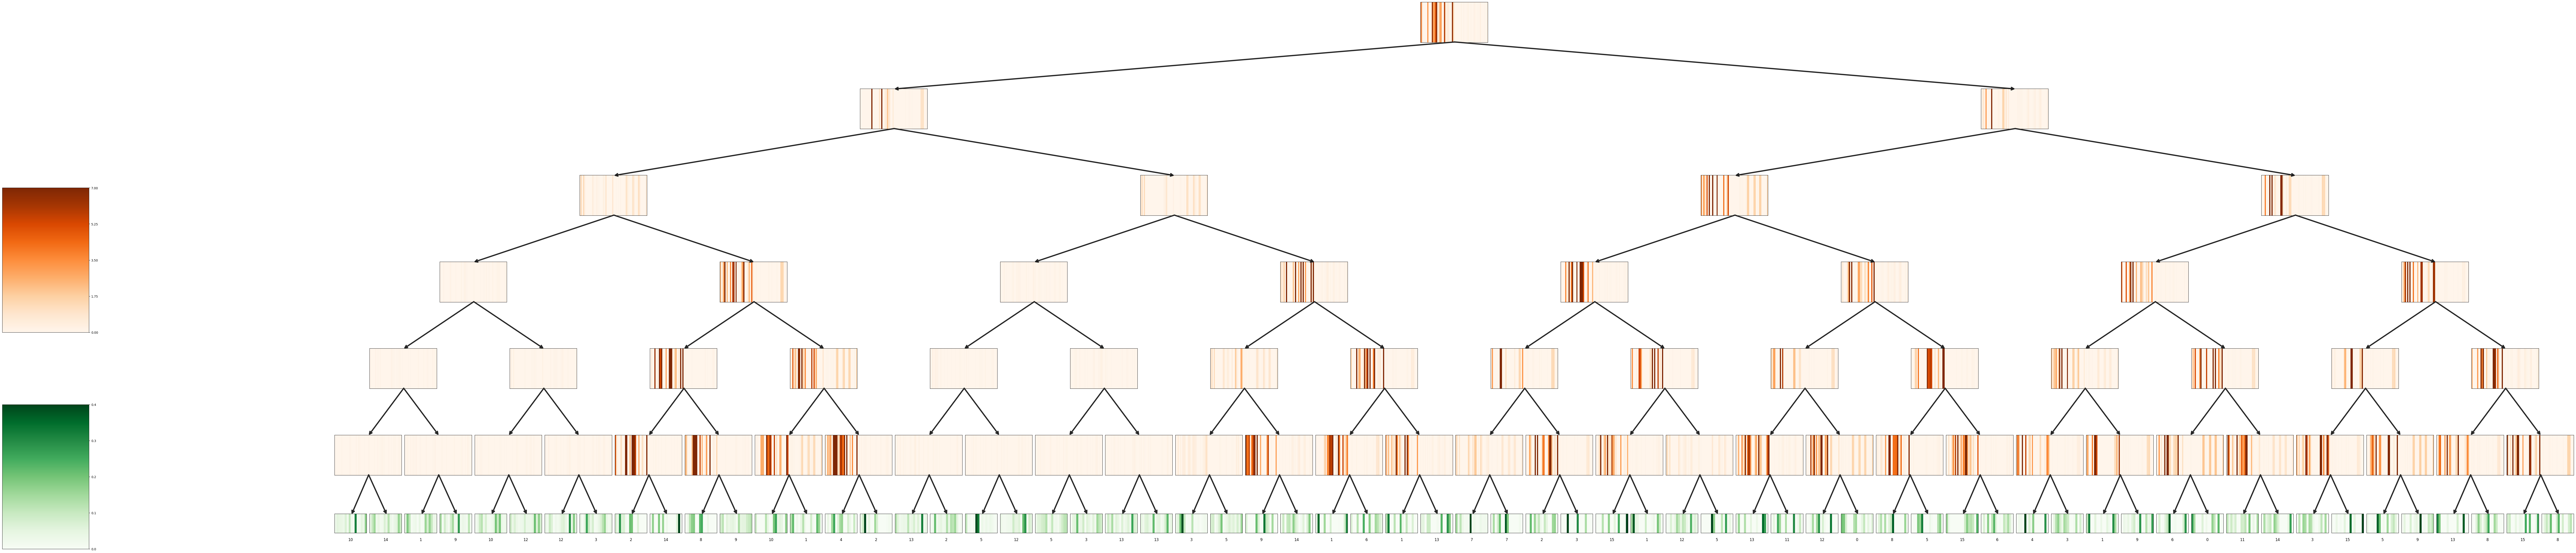

In [3]:
# 参数打印
num_params = 0
for key, v in tree.state_dict().items():
    print(key, v.reshape(-1).shape[0])
    num_params+=v.reshape(-1).shape[0]
print('Total number of parameters in model: ', num_params)

draw_tree(tree, input_img=None, DrawTree='DM', savepath='')